In [1]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters

In [2]:
%matplotlib inline

In [3]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [4]:
importlib.reload(lf)

<module 'letkf_forecasting' from '/home/travis/python_code/letkf_forecasting/letkf_forecasting.py'>

In [14]:
#for Golem
sat_14 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_14.nc')
sat_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_15.nc')
wind_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/wind_15_crop.nc')
sensor_data = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_data.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_loc.h5')

In [15]:
clear_sky_good = xr.DataArray(
    data=(sat_15.GHI.values/sat_14.GHI.values).clip(max=1),
    coords=sat_15.coords)

sat_15['clear_sky_good'] = clear_sky_good

In [16]:
sat_15 = sat_15.rename({'x': 'south_north', 'y': 'west_east'})

In [17]:
sensor_CI = sensor_data[['clearsky_index', 'id']]
sensor_CI = sensor_CI.reset_index().pivot(
    index='time', columns='id', values='clearsky_index')
sensor_CI = sensor_CI.resample('5min').mean().dropna() ##Use scipy interpolate instead of this.

In [18]:
#This is taken from http://www.groundcontrol.com/Satellite_Look_Angle_Calculator.html
goes15_azimuth = 220.5*(2*np.pi)/360
goes15_elevation = 44.1*(2*np.pi)/360

time = pd.Timestamp('2014-04-15 11:00:00').tz_localize('MST')
tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')
solar_position = tus.get_solarposition(time)
lf.parallax_shift(2000,
                     goes15_azimuth,
                     goes15_elevation,
                     solar_position['azimuth'].values*np.pi/360,
                     solar_position['elevation'].values*np.pi/360)

(array([-4502.7974688]), array([-2902.55179225]))

In [ ]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 1.2
assimilation_grid_size = 25
localization = 30

sat_sig = .01
sensor_sig = .1
ens_size = 40
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .03

start_time = '2014-04-15 13:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

lf.simulation(sat=sat_15, wind=wind_15, sensor_data=sensor_CI,
              sensor_loc=sensor_loc,
              start_time=start_time, end_time=end_time, dx=dx, dy=dy,
              C_max=C_max,
              assimilation_grid_size=assimilation_grid_size,
              localization_length=localization,
              sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
              wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma)

In [19]:
# Better Crop should write as a function into letkf_forecasting
long_min = sensor_loc['lon'].min()
long_max = sensor_loc['lon'].max()
lat_min = sensor_loc['lat'].min()
lat_max = sensor_loc['lat'].max()
long = sat_15.long.values
lat = sat_15.lat.values
min_x = abs(long[0, :] - long_min).argmin()
max_x = abs(long[0, :] - long_max).argmin()
min_y = abs(lat[:, 0] - lat_min).argmin()
max_y = abs(lat[:, 0] - lat_max).argmin()

U_max = wind_15.U.max() # know U is positive
V_max = abs(wind_15.V.min()) # know V is negative

left = int(U_max*60*30/250) + 20
right = 20

up = int(V_max*60*30/250) + 20
down = 20

x_crop = slice(min_x - left, max_x + right)
y_crop = slice(min_y - down, max_y + up)
print('X length: ' + 
      str(max_x + right - (min_x - left)))
print('Y length: ' + 
      str(max_y + up - (min_y - down)))

X length: 469
Y length: 330


In [ ]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 1.2
assimilation_grid_size = 25
localization = 30

sat_sig = 0.05 #0.01
sensor_sig = 0.05 #0.1
ens_size = 40
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .1

start_time = '2014-04-15 13:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 14:00:00' #Gets boring shortly after 14:00:00

x_crop_stag = slice(x_crop.start - 1, x_crop.stop)
y_crop_stag = slice(y_crop.start - 1, y_crop.stop)

lf.simulation(sat=sat_15.isel(y=x_crop, x=y_crop),
              wind=wind_15.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                                south_north=y_crop, south_north_stag=y_crop_stag),
              sensor_data=sensor_CI,
              sensor_loc=sensor_loc,
              start_time=start_time, end_time=end_time, dx=dx, dy=dy,
              C_max=C_max,
              assimilation_grid_size=assimilation_grid_size,
              localization_length=localization,
              sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
              wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma)

In [20]:
U = filters.uniform_filter(wind_15.U, (0, 300, 300), mode='mirror')
V = filters.uniform_filter(wind_15.V, (0, 300, 300), mode='mirror')

In [21]:
wind_15_smooth = wind_15.copy()

In [22]:
wind_15_smooth['U'] = (wind_15.U.dims, U)
wind_15_smooth['V'] = (wind_15.V.dims, V)

In [24]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 1.2
assimilation_grid_size = 25
localization = 30

sat_sig = 0.01 #0.01
sensor_sig = 0.05 #0.1
ens_size = 40
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .1

start_time = '2014-04-15 13:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 14:00:00' #Gets boring shortly after 14:00:00

x_crop_stag = slice(x_crop.start - 1, x_crop.stop)
y_crop_stag = slice(y_crop.start - 1, y_crop.stop)



analysis, background = lf.trimmed_simulation(sat=sat_15.isel(west_east=x_crop,
                                                             south_north=y_crop),
              wind=wind_15_smooth.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                                south_north=y_crop, south_north_stag=y_crop_stag),
              sensor_data=sensor_CI,
              sensor_loc=sensor_loc,
              start_time=start_time, end_time=end_time, dx=dx, dy=dy,
              C_max=C_max,
              assimilation_grid_size=assimilation_grid_size,
              localization_length=localization,
              sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
              wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma)


time_index: 0
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 1
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 2
advection_number: 0
advection_number: 1
advection_number: 2
advection_number: 3
advection_number: 4
advection_number: 5


In [25]:
analysis = analysis.isel(time=slice(1, None))
analysis.name = 'analysis'
background = background.isel(time=slice(1, None))
background.name = 'background'

In [26]:
file = xr.merge((background, analysis))
file.to_netcdf(
    '/home/travis/python_code/letkf_forecasting/results/background_analysis_{date}.nc'
    .format(date=datetime.date.today()))

In [28]:
ens_average = file.mean(dim='ens_num')
ens_average = ens_average.isel(element=slice(2, None))

/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


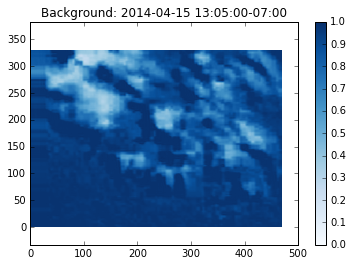

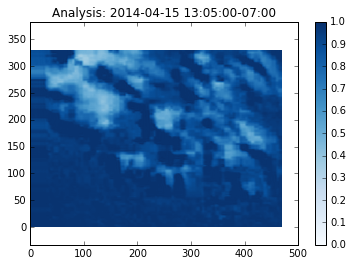

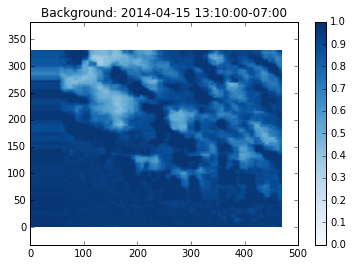

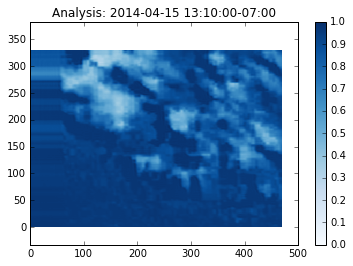

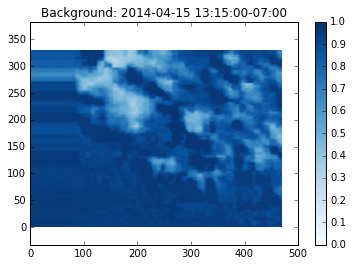

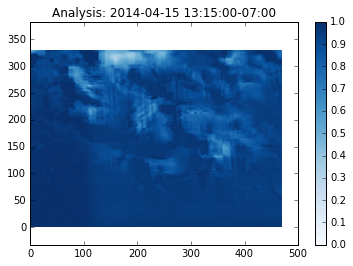

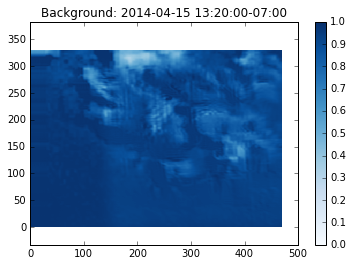

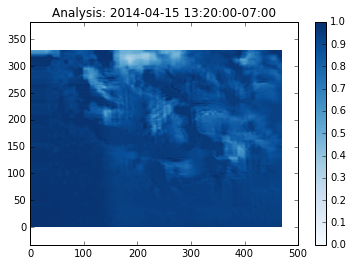

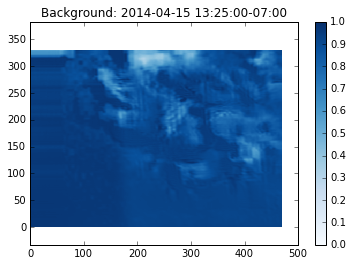

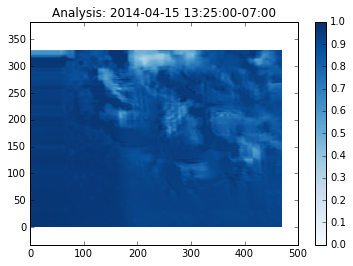

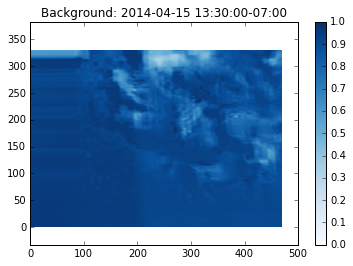

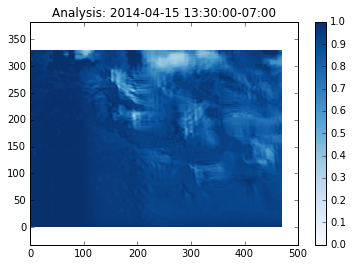

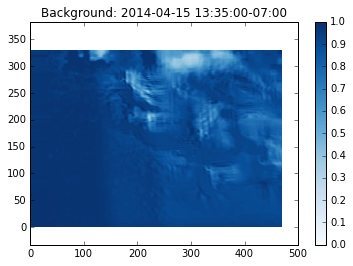

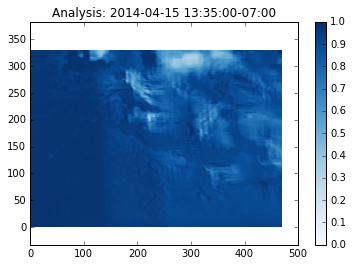

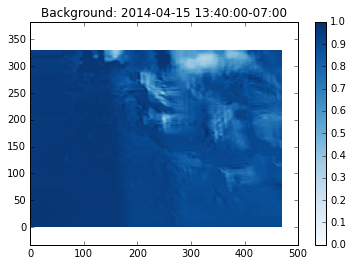

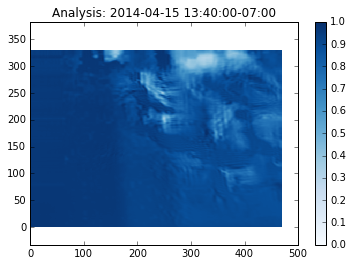

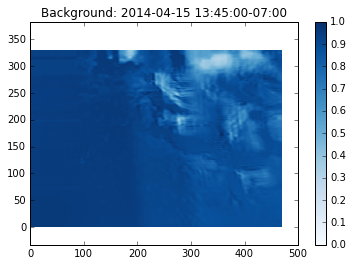

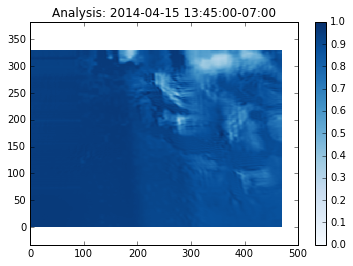

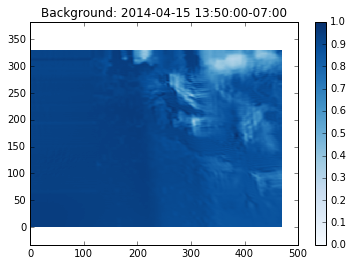

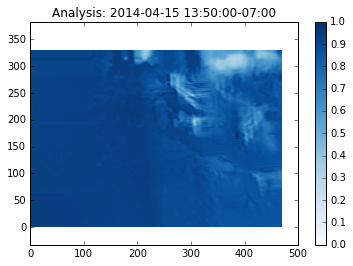

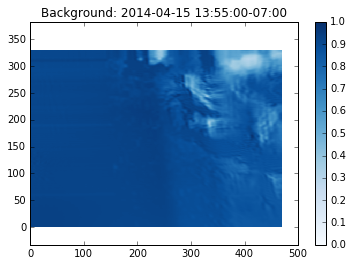

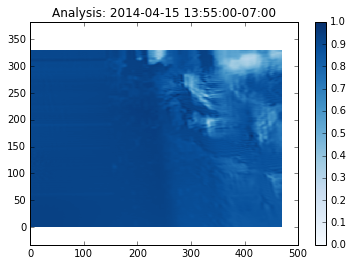

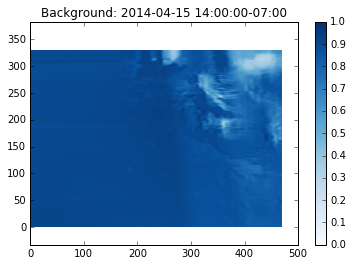

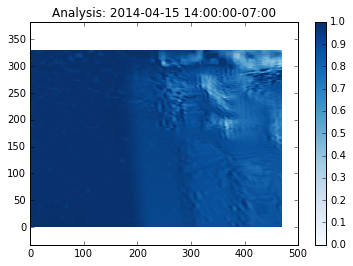

In [31]:
shape = (330, 469)
for t in file.time.values:
    this_time = pd.to_datetime(t).tz_localize('UTC').tz_convert('MST')
    plt.figure()
    im = plt.pcolormesh(
        ens_average.background.sel(time=t).values.reshape(shape),
        cmap='Blues', vmin=0, vmax=1)
    plt.colorbar(im)
    plt.title('Background: ' + str(this_time))
    plt.axis('equal')
    
    plt.figure()
    im = plt.pcolormesh(
        ens_average.analysis.sel(time=t).values.reshape(shape),
        cmap='Blues', vmin=0, vmax=1)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')